In [1]:
%%writefile -a cloudstack.py

from random import randint
import numpy as np
import matplotlib.pyplot as plt


In [15]:
%%writefile -a cloudstack.py

"""Class service offering that contains possible flavor of the system

This class used by cloudstack to generate a Virtual Machines. There is no ratio limit between CPU and Memory
"""

class ServiceOffering:
    
    def __init__(self, _id, CPU_count, MAX_MEM):
        self.id = _id
        self.CPU_count = CPU_count
        self.MAX_MEM = MAX_MEM
        
    def __getitem__(self, field_name):
        if field_name == "id":
            return self.id
        elif field_name == "CPU_count":
            return self.CPU_count
        elif field_name == "MAX_MEM":
            return self.MAX_MEM
        else:
            return None
        
    def __str__(self) -> str:
        return "(CPU: " + str(self.CPU_count) + " core, memory: " + str(self.MAX_MEM) + "GB)"


In [3]:
"""Host is our abstraction of the real hypervisor

 For simplicity I assumed all the hosts have 2100 mhz CPU,
 I also assumed that overprovitioning factor is 1, if you need higher overprovitioning factor pass higher CPU_count, no worries it is free :)
"""

class Host:
    
    def __init__(self, name, CPU_count, MAX_MEM):
        self.name = name
        self.CPU_count = CPU_count
        self.MAX_MEM = MAX_MEM
        self.vms = []
        
    def run_vm(self, vm):
        if type(vm) is not VM:
            return
        
        if self.has_enough_resource_for(vm.so):
            self.vms.append(vm)
        else:
            raise Exception("Host doesn't have enough capacity for " + vm.name + " with the offering " + vm.so )
            
    def __getitem__(self, field_name):
        if field_name == "name":
            return self.name
        elif field_name == "CPU_count":
            return self.CPU_count
        elif field_name == "MAX_MEM":
            return self.MAX_MEM
        elif field_name == "vms":
            return self.vms
        else:
            return None
        
    def get_used_resources(self):
        return {
            "CPU_usage" : sum([vm.CPU_usage for vm in self.vms ]),
            "MEM_usage" : sum([vm.mem_usage for vm in self.vms ])
        }
    
    def get_allocated_resources(self):
        return {
            "CPU_allocated" : sum([vm.so.CPU_count for vm in self.vms ]),
            "MEM_allocated" : sum([vm.so.MAX_MEM for vm in self.vms ])
        }
    
    def get_free_resources(self):
        allocated = self.get_allocated_resources()
        return {
            "CPU_free" : self.CPU_count - allocated["CPU_allocated"],
            "MEM_free" : self.MAX_MEM - allocated["MEM_allocated"]
        }
    
    def has_enough_resource_for(self, service_offering):
        free = self.get_free_resources()
        return service_offering.CPU_count < free["CPU_free"] and service_offering.MAX_MEM < free["MEM_free"]

    def __str__(self):
        return "Name: " + self.name + "\nCPU: " + str(self.CPU_count) + " core\nmemory: " + str(self.MAX_MEM) + "GB\nVMs: " + str([str(vm.name) + " " for vm in self.vms ])

In [4]:
"""Host is our abstraction of the real hypervisor

 For simplicity I assumed all the hosts have 2100 mhz CPU,
 I also assumed that overprovitioning factor is 1, if you need higher overprovitioning factor pass higher CPU_count, no worries it is free :)
"""

class VM:
    
    def __init__(self, name, host, service_offering):
        self.name = name
        self.host = host
        self.so = service_offering
        self.CPU_usage = 0
        self.mem_usage = 0
        
    def update_usage(self):
        ## TODO: Using used memory rather than the allocation adds an unnecessary complexity to the project
        ## reserve minimum memory usage 20%
        ## Increase or decrease the current memory usage in range of 10% of the current memory usage
        ## reserve minimum cpu usage 10%
        ## Increase or decrease the current memory usage in range of 30% of the current memory usage
        return None
        
        
    def __str__(self):
        return "Name: " + self.name + "\nservice offering: " + str(self.so) +  "\nusage: (CPU: " + str(self.CPU_usage) + ", memory: " + str(self.mem_usage) + ")"

In [12]:
class CloudStack:
    
    def __init__(self, policy="random", host_count=0, host_memory=256, host_cpu_count=64, host_prefix="Node#"):
        self.policy = policy
        self.hosts = []
        self.vms = []
        
        for i in range(host_count):
            host = Host(host_prefix + str(i), host_cpu_count, host_memory)
            self.add_host(host)
    
    def deploy_vm(self, name, service_offering):
        host = self.select_host(service_offering)
        if host is None:
            return None
        vm = VM(name, host, service_offering);
        host.run_vm(vm)
        self.vms.append(vm)   
        return vm
        
    def add_host(self, host):
        if type(host) is not Host:
            return
        self.hosts.append(host)
                  
    def select_host(self, service_offering):
        # TODO implement more policies
        if self.policy == "random":
            host_indexes = np.arange(len(self.hosts))
            np.random.shuffle(host_indexes)
            for i in host_indexes:
                candidate_host = self.hosts[i]
                if candidate_host.has_enough_resource_for(service_offering):
                    return candidate_host
            return None
        
        elif self.policy == "firstfit":
            for host in self.hosts:
                if host.has_enough_resource_for(service_offering):
                    return host
            return None
        
        elif self.policy == "leastconsumed":
            dtype = [('name', 'U10'), ('CPU_free', int), ('MEM_free', int)]
            
            host_statuses = np.array(self.get_hosts_statuses() , dtype=dtype)
            host_statuses = np.sort(host_statuses, order=['CPU_free', 'MEM_free'])[::-1]
            
            for status in host_statuses:
                candidate_host = [h for h in self.hosts if h.name == status[0]][0]
                if candidate_host.has_enough_resource_for(service_offering):
                    return candidate_host
            return None
            
        else:
            raise Exception("Policy " + self.policy + " doesn't have any implementation.")
        
        
    def get_hosts_statuses(self):
        return [(h.name, h.get_free_resources()["CPU_free"], h.get_free_resources()["MEM_free"]) for h in self.hosts]
    
    def get_max_memory(self):
        return max([ h.MAX_MEM for h in self.hosts])
    
    def get_max_cpu_count(self):
        return max([ h.CPU_count for h in self.hosts])

In [6]:

# Available flavors in all cloudstack instances    
service_offerings = np.array([ServiceOffering(0,1,1),
                     ServiceOffering(1,1,2),
                     ServiceOffering(2,2,2),
                     ServiceOffering(3,2,4),
                     ServiceOffering(4,4,4),
                     ServiceOffering(5,4,8),
                     ServiceOffering(6,8,16),
                     ServiceOffering(7,8,32),
                     ServiceOffering(8,16,64)])

cs = CloudStack(host_count=10)


# host = Host("Samar", 64, 256)

#print("\n\n".join(map(str,cs.hosts)))

# cs.add_host(host)
for i in range(50):
    cs.deploy_vm("VM#" + str(i) , service_offerings[randint(0,len(service_offerings)-1)])
#cs.deploy_vm("Ghamar", service_offerings[randint(0,len(service_offerings)-1)])
#cs.deploy_vm("Gholi", service_offerings[randint(0,len(service_offerings)-1)])



#print("\n".join(map(str,cs.hosts)))
#print()
#print("\n\n".join(map(str,cs.vms)))

print(np.random.choice(service_offerings,2, p=[0.20,0.15,0.13,0.12,0.1,0.1,0.1,0.05,0.05])[0])

(CPU: 1 core, memory: 1GB)


In [7]:
cs.get_hosts_statuses()

[('Node#0', 23, 128),
 ('Node#1', 20, 108),
 ('Node#2', 35, 154),
 ('Node#3', 33, 153),
 ('Node#4', 53, 237),
 ('Node#5', 31, 162),
 ('Node#6', 45, 205),
 ('Node#7', 44, 185),
 ('Node#8', 45, 186),
 ('Node#9', 37, 172)]

In [8]:
cs = CloudStack(host_count=10, policy="leastconsumed")


# host = Host("Samar", 64, 256)

#print("\n\n".join(map(str,cs.hosts)))

# cs.add_host(host)
cs.deploy_vm("Ghamar", service_offerings[randint(0,len(service_offerings)-1)])
cs.deploy_vm("Gholi", service_offerings[randint(0,len(service_offerings)-1)])
cs.deploy_vm("Samar", service_offerings[randint(0,len(service_offerings)-1)])
cs.deploy_vm("Mamar", service_offerings[randint(0,len(service_offerings)-1)])
cs.deploy_vm("Ghamar", service_offerings[randint(0,len(service_offerings)-1)])
cs.deploy_vm("Gholi", service_offerings[randint(0,len(service_offerings)-1)])
cs.deploy_vm("Samar", service_offerings[randint(0,len(service_offerings)-1)])
cs.deploy_vm("Mamar", service_offerings[randint(0,len(service_offerings)-1)])


#print("\n".join(map(str,cs.hosts)))
#print()
#print("\n\n".join(map(str,cs.vms)))

cs.get_hosts_statuses()

[('Node#0', 64, 256),
 ('Node#1', 64, 256),
 ('Node#2', 62, 252),
 ('Node#3', 60, 248),
 ('Node#4', 63, 255),
 ('Node#5', 48, 192),
 ('Node#6', 63, 254),
 ('Node#7', 63, 254),
 ('Node#8', 62, 254),
 ('Node#9', 63, 254)]

In [9]:
print("MEM_usage:" , cs.hosts[0].get_used_resources()["MEM_usage"])
print("MEM_allocated:" , cs.hosts[0].get_allocated_resources()["MEM_allocated"])
print("MEM_free:" , cs.hosts[0].get_free_resources()["MEM_free"])

MEM_usage: 0
MEM_allocated: 0
MEM_free: 256


In [22]:
def plot_hosts_CPU(cs, service_offerings):
    plot_hosts(cs, service_offerings, "CPU_count", cs.get_max_cpu_count() + 1, Y_steps=8)
    
def plot_hosts_memory(cs, service_offerings):
    plot_hosts(cs, service_offerings, "MAX_MEM", cs.get_max_memory() + 1, Y_steps=16)

def plot_hosts(cs, service_offerings, Y, MAX, Y_steps):
    
    data = np.array([[0]*len(cs.hosts)]*len(service_offerings))
    
    columns = [h.name for h in cs.hosts]
    rows = ['%dGB Memory' % of[Y] for of in service_offerings]
    
    for i in range(len(cs.hosts)):
        for vm in cs.hosts[i].vms:
            data[vm.so.id][i] += 1
    
    values = np.arange(0, MAX, Y_steps)

    # Get some pastel shades for the colors
    colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))
    n_rows = len(data)

    index = np.arange(len(columns)) + 0.3
    bar_width = 0.5

    # Initialize the vertical-offset for the stacked bar chart.
    y_offset = np.zeros(len(columns))

    # Plot bars and create text labels for the table
    cell_text = []
    for row in range(n_rows):
        plt.bar(index, data[row]* service_offerings[row][Y], bar_width, bottom=y_offset, color=colors[row])
        y_offset = data[row]* service_offerings[row][Y]
        cell_text.append([ x for x in y_offset])


    # Add a table at the bottom of the axes
    the_table = plt.table(cellText=cell_text,
                          rowLabels=rows,
                          rowColours=colors,
                          colLabels=columns,
                          loc='bottom')

    # Adjust layout to make room for the table:
    plt.subplots_adjust(left=0.2, bottom=0.2)

    plt.ylabel("Memory Usage")
    plt.yticks(values, ['%d' % val for val in values])
    plt.xticks([])
    plt.title('Host Status')

    plt.show()

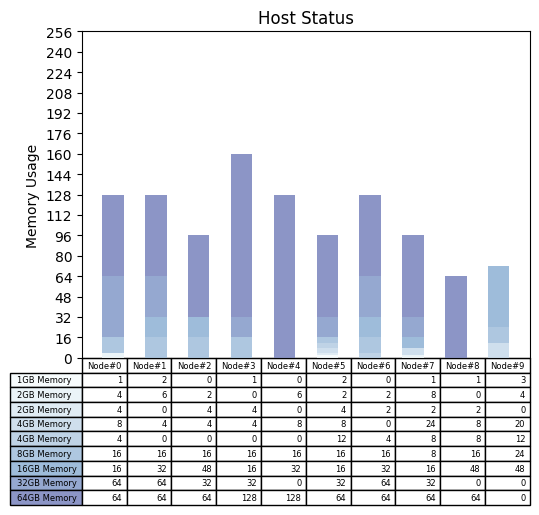

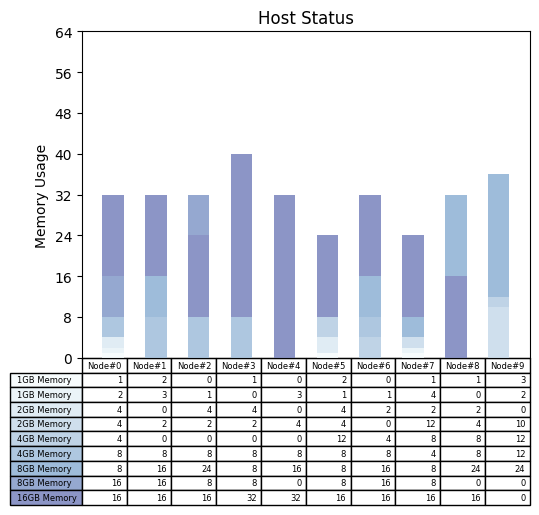

In [25]:
cs = CloudStack(host_count=10, policy="firstfit")
for i in range(150):
    cs.deploy_vm("VM#" + str(i) , service_offerings[randint(0,len(service_offerings)-1)])


plot_hosts_memory(cs,service_offerings)
plot_hosts_CPU(cs,service_offerings)

In [26]:
print(service_offerings[0]["MAX_MEM"])

1


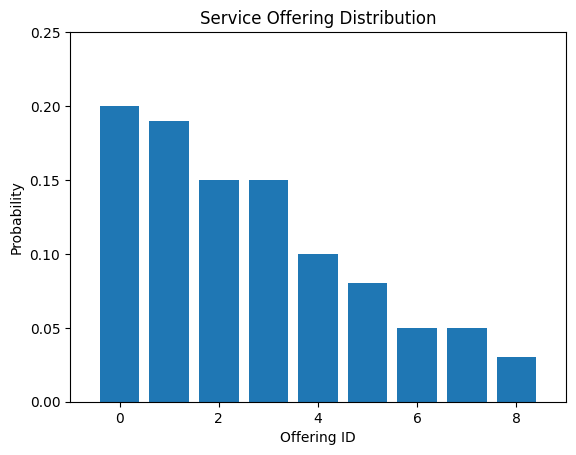

In [63]:

distribution = [0.20, 0.19, 0.15, 0.15, 0.10, 0.08, 0.05, 0.05, 0.03]

def plot_service_offering_distribution(distribution):
    # the histogram of the data
    ids = range(len(distribution))

    plt.bar(ids, distribution)

    plt.xlabel("Offering ID")
    plt.ylabel("Probability")
    plt.title("Service Offering Distribution")
    plt.xlim(-1, 9)
    plt.ylim(0, 0.25)
    plt.show()
    
plot_service_offering_distribution(distribution)